# ADMM TGV CT Reconstruction

Alternating Directions Method of Multipliers algorithm to solve Total Generalized Variation CT reconstruction problem.

This algorithm solves the following optimization:
\begin{equation}
 \min_{\mathbf{x},\mathbf{V}} \frac{1}{2\lambda} ||{\mathbf{MAx - s}}||_2^2 + \alpha_0||[\nabla_1\mathbf{v_1},\nabla_2\mathbf{v_2}, \frac{1}{2}(\nabla_1\mathbf{v_2} + \nabla_2\mathbf{v_1})]||_{2,1} + \alpha_1||[\nabla_1\mathbf{x},\nabla_2\mathbf{x}] -\mathbf{V}||_{2,1}
\end{equation}
 where the $\ell_{2,1}$ norm is defined as
 $$||\mathbf{V}||_{2,1} = \sum_i \left(\sum_j |v_{ij}|^2 \right)^{1/2}. $$

In [9]:
import numpy as np
from scipy.sparse.linalg import cg, LinearOperator
from scipy.sparse import identity
import scipy.io as sio
from PIL import Image
from utils import *
import time, itertools

The optimization problem in (1) has the following equivalent form
\begin{align*}
 \min_{\mathbf{x},\mathbf{V}, \mathbf{Z}, \mathbf{Y}}\quad &\frac{1}{2} ||{\mathbf{MAx - s}}||_2^2 + \lambda(\alpha_0||\mathbf{Y}||_{2,1} + \alpha_1||\mathbf{Z}||_{2,1}) \\
 \text{s.t.}\quad  &\mathbf{Z} = [\nabla_1\mathbf{x},\nabla_2\mathbf{x}] - \mathbf{V} \\
         &\mathbf{Y} = [\nabla_1\mathbf{v_1},\nabla_2\mathbf{v_2}, \frac{1}{2}(\nabla_1\mathbf{v_2} + \nabla_2\mathbf{v_1})]
\end{align*}
giving us the following update steps:

## x-step
$$ 
\mathbf{x}^{k+1} \leftarrow \argmin_{\mathbf{x}} \frac{1}{2} ||{\mathbf{MAx - s}}||_2^2 + \rho_Z ||\mathbf{Z}^k - [\nabla_1\mathbf{x},\nabla_2\mathbf{x}] + \mathbf{V}^k + \mathbf{U}_Z^k||_{F}^2 
$$
since this is quadratic we can derive the closed form solution
$$
\mathbf{x}^{k+1} = \left[\mathbf{A^T M^T M A} + 2\rho_Z (\nabla_1^T \nabla_1 + \nabla_2^T \nabla_2) \right]^{-1} \left( \mathbf{A^T M^T s} + 2\rho_Z (\nabla_1^T(\mathbf{Z_1^k + v_1^k + {U_Z}_1^k}) + \nabla_2^T(\mathbf{Z_2^k + v_2^k + {U_Z}_2^k})) \right)
$$

In [10]:
def x_step(self, A, M, iter, tol):
        """Compute x-step using conjugate gradient method"""

        def matvec(x):
                y1 = A.transpose() @ (M * (A @ x))
                y2 = 2 * self.rho_z * adj_grad_op_x(grad_op_x(np.reshape(x, self.x.shape))).flatten()
                return y1 + y2

        #B = A.transpose() @ A.multiply(M.reshape((-1,1)))/self.lam - 2*self.rho_z*(D1.transpose() @ D1 + D2.transpose() @ D2) 
        #temp1 = D1.transpose() @ (self.Z[:,0] + self.V[:,0] + self.Uz[:,0])
        #temp2 = D2.transpose() @ (self.Z[:,1] + self.V[:,1] + self.Uz[:,1])
        b = (A.transpose() @ (M * self.s.flatten())) + 2 * self.rho_z * adj_grad_op_x(self.Z + self.V + self.Uz).flatten()
        x, _ = cg(LinearOperator(matvec=matvec, shape=(self.x.size, self.x.size)), b, maxiter=iter, tol=tol, x0=self.x.flatten())
        self.x = x.reshape(self.x.shape)

## V-step
This step is given by
$$ 
\mathbf{V}^{k+1} \leftarrow \argmin_{\mathbf{V}} \rho_Z ||\mathbf{Z}^k - [\nabla_1\mathbf{x}^{k+1},\nabla_2\mathbf{x}^{k+1}] + \mathbf{V} + \mathbf{U}_Z^k||_{F}^2 + \rho_Y ||\mathbf{EV} - \mathbf{Y}^k + \mathbf{U}_Y^k||_{F}^2
$$
where $\mathbf{EV} = [\nabla_1\mathbf{v_1},\nabla_2\mathbf{v_2}, \frac{1}{2}(\nabla_1\mathbf{v_2} + \nabla_2\mathbf{v_1})]$. By flattening all vectors the Frobenius norm becomes equivalent to the $\ell_2$ norm. Hence we get the following closed form solution for $\mathbf{V}$
$$
\mathbf{V} = \left[2\rho_Z \mathbf{I} + 2\rho_Y \mathbf{E}^T\mathbf{E} \right]^{-1} \left(2\rho_Z([\nabla_1\mathbf{x}^{k+1},\nabla_2\mathbf{x}^{k+1}] - \mathbf{Z}^k -  \mathbf{U}_Z^k) + 2\rho_Y\mathbf{E}^T(\mathbf{Y}^k - \mathbf{U}_Y^k) \right).
$$
The operator $\mathbf{E}$ is given by 
\begin{equation*}
\mathbf{E} = \begin{bmatrix} \nabla_1 & 0 \\ 0 & \nabla_2 \\ \nabla_2 / 2 & \nabla_1 /2 \end{bmatrix}.
\end{equation*}

In [32]:
def V_step(self, Dx, iter, tol):
        """Compute V-step using conjugate gradient method"""
        def A(v):
                y1 = 2 * self.rho_z * v
                y2 = 2 * self.rho_y * adj_grad_op_V(grad_op_V(v.reshape(self.V.shape))).flatten()
                return y1 + y2

        EtYU = adj_grad_op_V(self.Y - self.Uy)
        b = 2*self.rho_z*(Dx - self.Z - self.Uz) + 2*self.rho_y*EtYU

        V, _ = cg(LinearOperator(matvec=A, shape=(self.V.size, self.V.size)), b.flatten(), maxiter=iter, tol=tol, x0=self.V.flatten())
 
        self.V = np.reshape(V, self.V.shape)

## Z-step
$$ 
\mathbf{Z}^{k+1} \leftarrow \argmin_{\mathbf{Z}} \lambda\alpha_1 ||\mathbf{Z}||_{2,1} + \rho_Z || \mathbf{Z} - [\nabla_1\mathbf{x}^{k+1},\nabla_2\mathbf{x}^{k+1}] + \mathbf{V}^{k+1} + \mathbf{U}_Z^k||_{F}^2 
$$
This step is separable in the rows of the matrix thanks to the Frobenius and $\ell_{2,1}$ norms. We can write the function as
$$
\sum_i \left[ \lambda\alpha_1 \left( \sum_j |\mathbf{Z}_{ij}|^2 \right)^{1/2} + \rho_Z \sum_j |(\mathbf{Z} - [\nabla_1\mathbf{x}^{k+1},\nabla_2\mathbf{x}^{k+1}] + \mathbf{V}^{k+1} + \mathbf{U}_Z^k)_{ij}|^2 \right]
$$
so minimizing the whole expression boils down to minimizing each row in parallel. That is
$$
\mathbf{Z}_i^{k+1} \leftarrow \argmin_{\mathbf{z}} \lambda\alpha_1 ||z||_2 + \rho_Z ||z - [\nabla_1\mathbf{x}^{k+1},\nabla_2\mathbf{x}^{k+1}]_i + \mathbf{V}^{k+1}_i + {\mathbf{U}_Z}^k_i ||_2^2
$$ 
which equals the proximal $\ell_2$ map
$$
\mathbf{Z}_i^{k+1} = \text{prox}_{2 \lambda\alpha_1 / \rho_Z, \ell_2} \left([\nabla_1\mathbf{x}^{k+1},\nabla_2\mathbf{x}^{k+1}]_i - \mathbf{V}^{k+1}_i - {\mathbf{U}_Z}^k_i \right).
$$
The $\ell_2$ proximal map has the following closed form solution
$$ \text{prox}_{\lambda, \ell_2} (\mathbf{a}) = \left(1 - \frac{\lambda}{||\mathbf{a}||_2} \right)_+ \mathbf{a}. $$

In [12]:
def Z_step(self, Dx):
      """Proximal gradient for l2 norm"""
      a = (Dx - self.V - self.Uz).reshape(-1, 2)
      coef = np.maximum(1 - (2 * self.lam * self.alpha_1 / self.rho_z) / np.linalg.norm(a, axis=1), 0).reshape(-1, 1)
      self.Z = (coef * a).reshape(self.Z.shape)

## Y-step
$$ 
\mathbf{Y}^{k+1} \leftarrow \argmin_{\mathbf{Y}} \lambda\alpha_0 ||\mathbf{Y}||_{2,1} + \rho_Y ||[\nabla_1\mathbf{v_1}^{k+1},\nabla_2\mathbf{v_2}^{k+1}, \frac{1}{2}(\nabla_1\mathbf{v_2}^{k+1} + \nabla_2\mathbf{v_1}^{k+1})] - \mathbf{Y} + \mathbf{U}_Y^k||_F^2
$$
As in the Z-step, we can again split this step into parallel subproblems for each row. Upon doing so we end up with
$$
\mathbf{Y}_i^{k+1} = \text{prox}_{2 \lambda\alpha_0 / \rho_Y, \ell_2} \left([\nabla_1\mathbf{v_1}^{k+1},\nabla_2\mathbf{v_2}^{k+1}, \frac{1}{2}(\nabla_1\mathbf{v_2}^{k+1} + \nabla_2\mathbf{v_1}^{k+1})] + \mathbf{U}_Y^k \right).
$$

In [13]:
def Y_step(self, DV):
      """Proximal gradient for l2 norm"""
      a = (DV + self.Uy).reshape(-1, 3)
      coef = np.maximum(1 - (2 * self.lam * self.alpha_0 / self.rho_y) / np.linalg.norm(a, axis=1), 0).reshape(-1, 1)
      self.Y = (coef * a).reshape(self.Y.shape)

## Dual steps
$$
\mathbf{U}_Z^{k+1} \leftarrow \mathbf{U}_Z^{k} + \mathbf{Z}^{k+1} - [\nabla_1\mathbf{x}^{k+1},\nabla_2\mathbf{x}^{k+1}] + \mathbf{V}^{k+1}. \\
\mathbf{U}_Y^{k+1} \leftarrow \mathbf{U}_Y^{k} + [\nabla_1\mathbf{v_1}^{k+1},\nabla_2\mathbf{v_2}^{k+1}, \frac{1}{2}(\nabla_1\mathbf{v_2}^{k+1} + \nabla_2\mathbf{v_1}^{k+1})] - \mathbf{Y}^{k+1}.
$$

In [14]:
def dual_step(self, Dx, Dv):
    """Dual variable updates"""
    self.Uz += self.Z - Dx + self.V
    self.Uy += Dv - self.Y

## Gradient operators

In [26]:
def grad_op_x(x, w1=1, w2=1):
    # Calculate Dx1, Dx2
    Dx1 = (np.roll(x, 1, 0) - x) / 2 * w1
    Dx2 = (np.roll(x, 1, 1) - x) / 2 * w2

    # Concatenate Dx1, Dx2, along the third axis
    Dx = np.concatenate((Dx1[..., np.newaxis], Dx2[..., np.newaxis]), axis=2)
    return Dx

def adj_grad_op_x(x, w1=1, w2=1):
    y1 = (np.roll(x[..., 0], -1, 0) - x[..., 0]) / 2 * w1
    y2 = (np.roll(x[..., 1], -1, 1) - x[..., 1]) / 2 * w2
    return y1 + y2

def grad_op_V(V):
    D1v1 = (np.roll(V[..., 0], 1, 0) - V[..., 0]) / 2
    D2v2 = (np.roll(V[..., 1], 1, 1) - V[..., 1]) / 2
    D2v1 = (np.roll(V[..., 0], 1, 1) - V[..., 0]) / 2
    D1v2 = (np.roll(V[..., 1], 1, 0) - V[..., 1]) / 2
    EV = np.concatenate((D1v1[..., np.newaxis], D2v2[..., np.newaxis], (D1v2[..., np.newaxis] + D2v1[..., np.newaxis])/2), axis=2)
    return EV

def adj_grad_op_V(V):
    y1 = (np.roll(V[...,0], -1, 0) - V[...,0])/2 + (np.roll(V[...,2], -1, 1) - V[...,2])/2 * 0.5
    y2 = (np.roll(V[...,1], -1, 1) - V[...,1])/2 + (np.roll(V[...,2], -1, 0) - V[...,2])/2 * 0.5
    return np.concatenate((y1[..., np.newaxis], y2[..., np.newaxis]), axis=2)


In [16]:
def iter_rec(A, M, s, cg_iter=5, cg_tol=1e-8):
    
    def matvec(x):
        return A.transpose() @ (M * (A @ x))

    x_shape = (s.shape[0], s.shape[0])
    b = A.transpose() @ (M * s.flatten())
    x, _ = cg(LinearOperator(matvec=matvec, shape=(np.prod(x_shape),np.prod(x_shape))), b, maxiter=cg_iter, tol=cg_tol)
    return x.reshape(x_shape)

## ADMM TGV Solver

In [72]:
class ADMM_TGV():
    def __init__(self, lam=.01, rho_z=20, rho_y=20, alpha_0=2, alpha_1=1):
        """Alternating directions method of multipliers solver"""
        # Parameters
        self.lam = lam
        self.rho_z = rho_z
        self.rho_y = rho_y
        self.alpha_0 = alpha_0
        self.alpha_1 = alpha_1
        # Methods
        ADMM_TGV.x_step = x_step
        ADMM_TGV.V_step = V_step
        ADMM_TGV.Z_step = Z_step
        ADMM_TGV.Y_step = Y_step
        ADMM_TGV.dual_step = dual_step
        # Info dict to store convergence data
        self.info = {'cost_func': [], 'primal_res_Z': [], 'primal_res_Y': [], 'mean_iter_time': 0}

    def solve(self, A, M, s, maxiter=100, tol=1e-2, cg_iter=100, cg_tol=1e-8, verbose=True):
        """Solve optimization problem"""

        t0 = time.time()

        tau = 1.05

        self.s = s
        self.x = iter_rec(A, M, s, cg_iter, cg_tol) # init with simple iterative reconstruction: x = (AtMt*MA)^-1(AtMt*s)
        self.x = np.reshape(self.x, (s.shape[0], s.shape[0]))

        Dx = grad_op_x(self.x)

        self.V = Dx # [D1 x, D2 x]
        self.Z = Dx - self.V

        Dv = grad_op_V(self.V)

        self.Y = Dv
        self.Uz = self.Z - Dx + self.V
        self.Uy = Dv - self.Y

        iter_times = []

        for i in range(maxiter):
            if verbose: print('ADMM iter = ', i, end='\r')

            tt0 = time.time()

            self.rho_z *= tau
            self.rho_y *= tau
            
            self.x_step(A, M, cg_iter, cg_tol)
            
            Dx = grad_op_x(self.x)
            
            self.V_step(Dx, cg_iter, cg_tol)

            Dv = grad_op_V(self.V)

            self.Z_step(Dx)
            self.Y_step(Dv)
            self.dual_step(Dx, Dv)

            cost = self.calc_cost_func(Dv, Dx)
            if i != 0 and tol is not None and np.abs(self.info['cost_func'][-1] - cost) < tol:
                break

            res_Z, res_Y = self.calc_primal_residuals(Dv, Dx)
            self.info['primal_res_Z'].append(res_Z)
            self.info['primal_res_Y'].append(res_Y)
            self.info['cost_func'].append(cost)

            tt1 = time.time()
            iter_times.append(tt1 - tt0)

    
        t1 = time.time() - t0
        if verbose: print('ADMM time elapsed:', round(t1, 2))

        self.info['mean_iter_time'] = np.mean(iter_times)

        return self.x, t1
    
    def get_recon_error(self, gt):
        rmse = RMSE(self.x.flatten(), gt.flatten())
        nrmse = nRMSE(self.x.flatten(), gt.flatten())
        ssim = SSIM(self.x.flatten(), gt.flatten())
        return {'RMSE': rmse, 'nRMSE': nrmse, 'SSIM': ssim}
    
    def calc_cost_func(self, Dv, Dx):
        data = np.linalg.norm(M * (A @ self.x.flatten()) - self.s.flatten())**2 / 2
        pen1 = self.alpha_0 * l21_norm(Dv)
        pen2 = self.alpha_1 * l21_norm(Dx - self.V)
        return data + self.lam * (pen1 + pen2)
    
    def calc_primal_residuals(self, DV, Dx):
        res_Z = np.linalg.norm( self.Z - (Dx - self.V) )
        res_Y = np.linalg.norm( self.Y - DV )
        return res_Z, res_Y

# Tikhonov regularized reconstruction

We compare TGV to a solution given by Tikhonov Generalized regularization. The corresponding optimization problem is
$$
 \min_{\mathbf{x}} ||{\mathbf{MAx - s}}||_2^2 + \lambda (||\nabla_1\mathbf{x}||_2^2 + ||[\nabla_2\mathbf{x}||_2^2).
$$
This problem has the following analytical solution
$$
\mathbf{x} = (\mathbf{A^T M^T M A} + \lambda(\nabla_1^T \nabla_1 + \nabla_2^T \nabla_2))^{-1}\mathbf{A^T M^T s}
$$

In [18]:
def tikhonov(A, M, s, lam, cg_iter=5, cg_tol=1e-8):
    def matvec(x):
        y1 = A.transpose() @ (M * (A @ x))
        y2 = lam * adj_grad_op_x(grad_op_x(x.reshape(x_shape))).flatten()
        return y1 + y2

    x_shape = (s.shape[0], s.shape[0])
    b = A.transpose() @ (M * s.flatten())
    x, _ = cg(LinearOperator(matvec=matvec, shape=(np.prod(x_shape),np.prod(x_shape))), b, maxiter=cg_iter, tol=cg_tol)
    return x.reshape(x_shape)

# TV regularized reconstruction

We shall compare the results of vectorial TGV to TV regularized reconstruction. The corresponding TV problem is given by
$$
\min_{\mathbf{x}} \frac{1}{2}||\mathbf{MAx - s}||_2^2 + \lambda ||\nabla \mathbf{x}||_1
$$
or equivalently
\begin{align*}
\min_{\mathbf{x, z}} &\frac{1}{2}||\mathbf{MAx - s}||_2^2 + \lambda||\mathbf{z}||_1\\
& \text{s.t. } \nabla \mathbf{x = z}.
\end{align*}
Here, $\nabla = \mathbf{D} = \begin{pmatrix} \nabla_1 \\ \nabla_2 \end{pmatrix}$.

We get the following ADMM updates
## x-step
$$
\mathbf{x}^{k+1} \leftarrow \argmin_{\mathbf{x}} \frac{1}{2}||\mathbf{MAx - s}||_2^2 + \frac{\rho}{2} ||\mathbf{Dx} - \mathbf{z}^k + \mathbf{u}^k||_2^2
$$
which amounts to evaluating the closed form solution
$$
\mathbf{x}^{k+1} = \left[\mathbf{A^T M^T M A} + \rho \mathbf{D^T D} \right]^{-1} \left(\mathbf{A^T M^T s} + \rho \mathbf{D^T}(\mathbf{z}^k - \mathbf{u}^k) \right).
$$

## z-step
$$
\mathbf{z}^{k+1} \leftarrow \argmin_{\mathbf{z}} \lambda||\mathbf{z}||_1 + \frac{\rho}{2} ||\mathbf{Dx}^{k+1} - \mathbf{z} + \mathbf{u}^k||_2^2
$$
this is simply equivalent to the $\ell_1$ proximal mapping
$$
\mathbf{z}^{k+1} = \text{prox}_{\lambda/\rho, \ell_1}\left(\mathbf{Dx}^{k+1} + \mathbf{u}^k \right)
$$
which is given by soft thresholding
$$
\text{prox}_{\lambda, \ell_1}(\mathbf{a})_i = \text{sign}(\mathbf{a}_i)\max(|\mathbf{a}_i| - \lambda, 0).
$$


## Dual-update
the dual step is simply given by
$$
\mathbf{u}^{k+1} \leftarrow \mathbf{u}^{k} + \mathbf{Dx}^{k+1} - \mathbf{z}^{k+1}.
$$

In [19]:
class ADMM_TV():
    def __init__(self, lam=0.1, rho=20):
        self.lam = lam
        self.rho = rho
        self.info = {'cost_func': [], 'primal_res': []}

    
    def solve(self, A, M, s, maxiter=100, tol=1e-2, cg_iter=100, cg_tol=1e-8, verbose=True):

        t0 = time.time()
        
        self.s = s
        self.x = iter_rec(A, M , s, cg_iter, cg_tol) # init with iterative reconstruction

        Dx = grad_op_x(self.x)
        self.z = Dx
        self.u = Dx - self.z

        for i in range(maxiter):
            self.rho *= 1.05
            print(f'ADMM TV iter = {i}', end='\r')

            self.x_step(A, M, s, cg_iter, cg_tol)
            Dx = grad_op_x(self.x)
            self.z_step(Dx)
            self.dual_step(Dx)

            cost = self.calc_cost_func(A, M, Dx)
            
            if i != 0 and tol is not None and np.abs(self.info['cost_func'][-1] - cost) < tol:
                break

            self.info['cost_func'].append(cost)
            self.info['primal_res'].append(self.calc_primal_residual(Dx))

        t1 = time.time() - t0
        
        if verbose: print('ADMM time elapsed:', round(t1, 2))
        
        return self.x, t1


    
    def x_step(self, A, M, s, cg_iter, cg_tol):
        def matvec(x):
            y1 = A.transpose() @ (M * (A @ x))
            y2 = self.rho * adj_grad_op_x(grad_op_x(x.reshape(self.x.shape))).flatten()
            return y1 + y2
        
        b = A.transpose() @ (M * self.s.flatten()) + self.rho * adj_grad_op_x(self.z - self.u).flatten()
        x, _ = cg(LinearOperator(matvec=matvec, shape=(self.x.size, self.x.size)), b.flatten(), x0 = self.x.flatten(), tol=cg_tol, maxiter=cg_iter)
        self.x = x.reshape(self.x.shape)

    def z_step(self, Dx):
        a = (Dx + self.u).flatten()
        prox = np.sign(a)*np.maximum(np.abs(a) - self.lam/self.rho, 0)
        self.z = prox.reshape(self.z.shape)

    def dual_step(self, Dx):
        self.u += Dx - self.z

    def calc_cost_func(self, A, M, Dx):
        data = np.linalg.norm(M * (A @ self.x.flatten()) - self.s.flatten()) **2
        pen = self.lam * np.linalg.norm(Dx.flatten(), ord=1)
        return data + pen
    
    def calc_primal_residual(self, Dx):
        return np.linalg.norm((Dx - self.z).flatten())


### Error metrics

In [20]:
    def patchify(x):
        """Return inscribed square in circle patch"""
        d = x.shape[0] # diameter of circle
        l = int(d / np.sqrt(2)) # length of square side
        start = int((d - l)/2)
        return x[start:start+l, start:start+l]
    
    def RMSE(x, gt, patch=True):
        if patch: x, gt = patchify(x), patchify(gt)
        return np.sqrt(np.mean((x - gt)**2))
    
    def nRMSE(x, gt, patch=True):
        if patch: x, gt = patchify(x), patchify(gt)
        return RMSE(x, gt) / np.std(x)

    def MAE(x, gt, patch=True):
        if patch: x, gt = patchify(x), patchify(gt)
        return np.mean(np.abs(x - gt))
    
    def SSIM(x, gt, patch=True):
        from skimage.metrics import structural_similarity as ssim
        if patch: x, gt = patchify(x), patchify(gt)
        return ssim(gt, x, full=True, data_range=gt.max()-gt.min())[0]

    def PSNR(x, gt, patch=True):
        if patch: x, gt = patchify(x), patchify(gt)
        return 20*np.log10(gt.max() / RMSE(x, gt) )


# Load data

In [23]:
file = '../../../invprob/Exercises/projects/2d_knee.mat' # change this to your location of 2d_knee.mat
slice = 5

def get_operators_and_data(size, slice=5, xi=.01, undersampling_method='sparse_view', acceleration_rate=2):
    # Downsize for faster computation
    shape = (size, size)
    image = np.array(sio.loadmat(file)['imgs'][:,:,slice])
    gt = np.asarray(Image.fromarray(image).resize(shape))
    #gt = (gt - gt.min()) / (gt.max() - gt.min())
    
    # If Radon matrix does not exist, create it
    path = os.path.join('radon', f'radon_mat_{size}.npz')
    if not os.path.exists(path):
        save_npz(path, radon_matrix(shape))
    # Load in pre-computed Radon transform matrix
    A = load_npz(path)
    # Generate ground truth sinogram
    gt_sin = (A @ gt.flatten()).reshape((size, 90))


    # Get undersampling matrix
    M = get_M(sin_shape=(size,90), undersampling_method=undersampling_method, undersampling_rate=1-1/acceleration_rate)

    s = gt_sin + np.random.normal(loc=0, scale=gt_sin.std()*xi, size=gt_sin.shape) # add Gaussian noise

    s = (M * s.flatten()).reshape(s.shape) # undersample

    s_fbp = (s.flatten()[M.astype(bool)]).reshape(size, -1) # save only sampled angles of sinogram for FBP reconstruction
    theta_fbp = np.arange(1, 180, step=2*acceleration_rate) # and corresponding angles theta

    return A, M, gt, gt_sin, s, s_fbp, theta_fbp

# Convergence

In [78]:
A, M, gt, gt_sin, s, *_ = get_operators_and_data(size=128, slice=50, acceleration_rate=2, xi=.05)

ADMM time elapsed: 46.0
0.20343705694060693


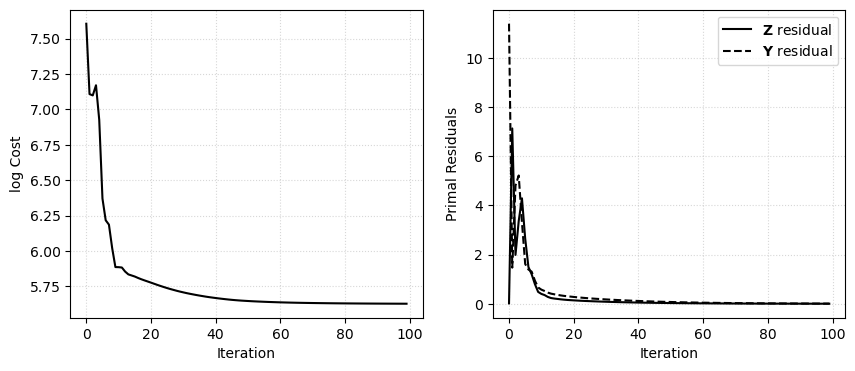

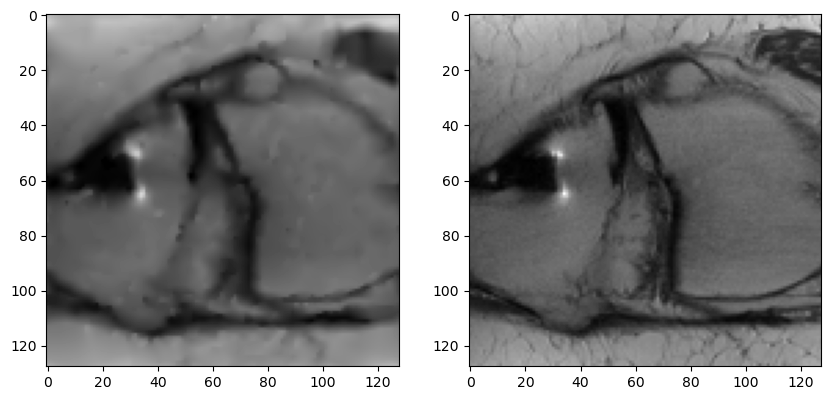

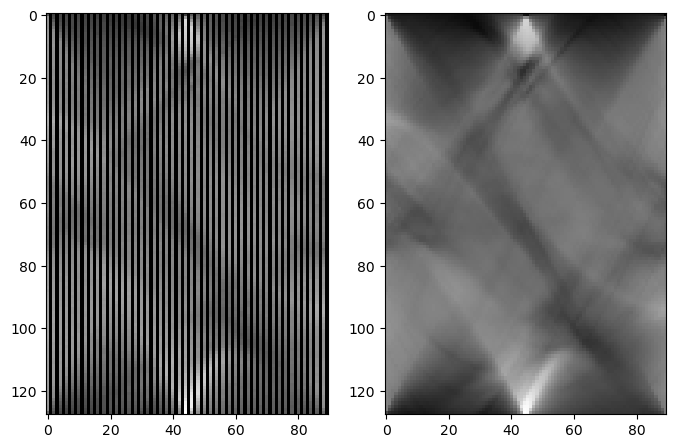

In [79]:
solver = ADMM_TGV(.7)
solver.solve(A, M, s)
conv_info = solver.info

fig, ax = plt.subplots(1,2, figsize=(10,4))

logcost = np.log(conv_info['cost_func'])
ax[0].plot(logcost, '-', label=r'log Cost', color='black')
ax[0].set_ylabel(r'log Cost')
ax[0].set_xlabel('Iteration')
#ax[0].set_title('log Cost')


ax[1].plot(conv_info['primal_res_Z'], '-', label=r'$\mathbf{Z}$ residual', color='black')
ax[1].plot(conv_info['primal_res_Y'], '--', label=r'$\mathbf{Y}$ residual', color='black')
ax[1].set_ylabel('Primal Residuals')
ax[1].set_xlabel('Iteration')
#ax[1].set_title('Primal residuals')
ax[1].legend()

ax[0].grid('on', alpha=0.5, linestyle='dotted')
ax[1].grid('on', alpha=0.5, linestyle='dotted')

#plt.suptitle('Convergence Metrics ADMM TGV')
plt.savefig('figs/conv_TGV.pdf', format='pdf')


fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(solver.x, cmap='gray', clim=[gt.min(), gt.max()])
axs[1].imshow(gt, cmap='gray')

print(nRMSE(solver.x, gt))

fig, axs = plt.subplots(1,2, figsize=(8,10))
axs[0].imshow(s, cmap='gray')
axs[1].imshow(gt_sin, cmap='gray')

plt.show()

ADMM time elapsed: 4.95
0.18159288456878145


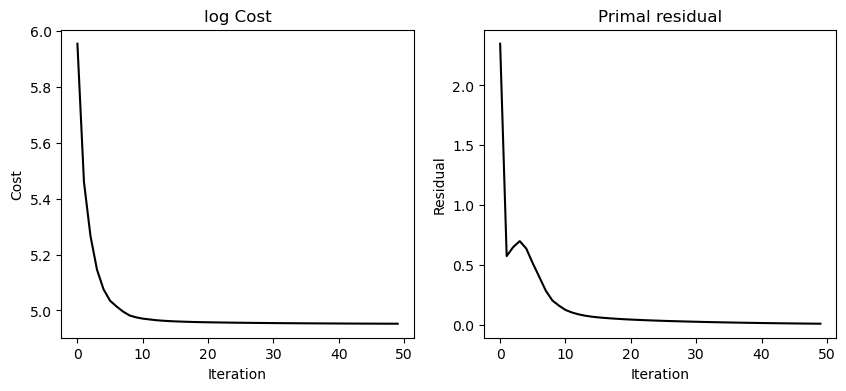

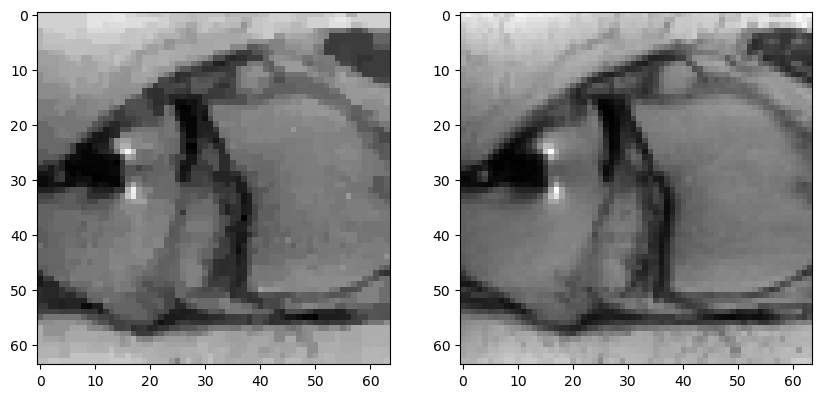

In [70]:
solver = ADMM_TV(lam=.6)
solver.solve(A, M, s, maxiter=100, cg_iter=100)    
conv_info = solver.info

fig, ax = plt.subplots(1,2, figsize=(10,4))

logcost = np.log(conv_info['cost_func'])
ax[0].plot(logcost, '-', label=r'log Cost', color='black')
ax[0].set_ylabel(r'Cost')
ax[0].set_xlabel('Iteration')
ax[0].set_title('log Cost')


ax[1].plot(conv_info['primal_res'], '-', color='black')
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('Iteration')
ax[1].set_title('Primal residual')

#plt.suptitle('Convergence Metrics ADMM TV')
plt.savefig('figs/conv_TV.pdf', format='pdf')


fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(solver.x, cmap='gray', clim=[gt.min(), gt.max()])
axs[1].imshow(gt, cmap='gray')
print(nRMSE(solver.x, gt))

plt.show()

# Parameter Tuning

In [87]:
# TAKES 7h ON MAC M1!!!

xis = np.arange(0, .051, 0.01) # noise levels to search over
tuning_sizes = [64, 128, 211]
optimal_lambdas = {s:list() for s in tuning_sizes}

dl = 0.02 # lambda step size

for s in tuning_sizes:
    
    print(f'size = {s}')
    best_lambda = 0

    for xi in xis:
        
        print(f'xi={xi:.2f}')
        l = best_lambda
        
        prev_err, err = 0, 0
        A, M, gt, gt_sin, sin, *_ = get_operators_and_data(size=s, slice=50, acceleration_rate=1, xi=xi)
        
        i = 0
        while True:

            solver = ADMM_TGV(l)
            solver.solve(A, M, sin, verbose=False) 
            
            err = nRMSE(solver.x, gt)

            if err > prev_err and i != 0: # if error increases save the previous lambda
                best_lambda = l - dl
                optimal_lambdas[s].append(best_lambda)
                break
            
            print(f'xi={xi:.2f}, lambda={l:.2f}, error={err:.3f}')
            prev_err = err
            l += dl
            i += 1

size = 64
xi=0.00
xi=0.00, lambda=0.00, error=0.037
xi=0.01
xi=0.01, lambda=0.00, error=0.208
xi=0.01, lambda=0.02, error=0.087
xi=0.01, lambda=0.04, error=0.069
xi=0.02
xi=0.02, lambda=0.04, error=0.141
xi=0.02, lambda=0.06, error=0.105
xi=0.02, lambda=0.08, error=0.097
xi=0.02, lambda=0.10, error=0.096
xi=0.03
xi=0.03, lambda=0.10, error=0.122
xi=0.03, lambda=0.12, error=0.118
xi=0.03, lambda=0.14, error=0.117
xi=0.04
xi=0.04, lambda=0.14, error=0.145
xi=0.04, lambda=0.16, error=0.140
xi=0.04, lambda=0.18, error=0.137
xi=0.04, lambda=0.20, error=0.135
xi=0.04, lambda=0.22, error=0.134
xi=0.04, lambda=0.24, error=0.133
xi=0.04, lambda=0.26, error=0.133
xi=0.05
xi=0.05, lambda=0.26, error=0.144
xi=0.05, lambda=0.28, error=0.143
xi=0.05, lambda=0.30, error=0.143
xi=0.05, lambda=0.32, error=0.143
size = 128
xi=0.00
xi=0.00, lambda=0.00, error=0.087
xi=0.00, lambda=0.02, error=0.072
xi=0.01
xi=0.01, lambda=0.02, error=0.119
xi=0.01, lambda=0.04, error=0.098
xi=0.01, lambda=0.06, error=0.0

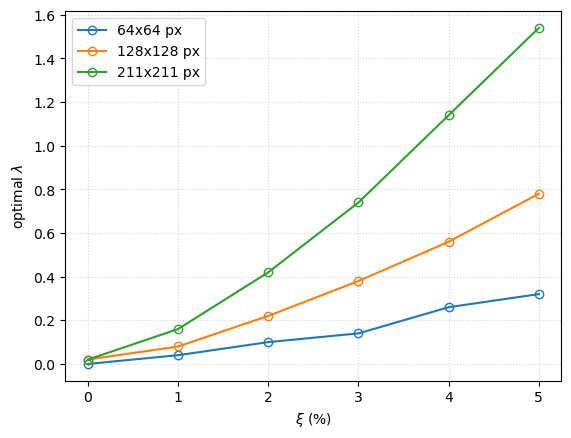

In [92]:
for s in tuning_sizes:
    plt.plot(100*xis, optimal_lambdas[s], 'o-', fillstyle='none', label=f'{s}x{s} px')
#plt.title('Penalty parameter grid search')
plt.xlabel(r'$\xi$ (%)')
plt.ylabel(r'optimal $\lambda$')
plt.xticks(100*xis)
plt.grid('on', linestyle='dotted', alpha=0.5)
plt.legend()
plt.savefig(f'figs/lambda_gridsearch.pdf', format='pdf')
plt.show()

# Comparison

ADMM time elapsed: 103.9
ADMM time elapsed: 83.86
Method & nRMSE (\%) & PSNR (dB) & SSIM\\ \hline 
FBP & 66.6 & 21.7 & 0.391\\ 
Tikhonov & 32.7 & 30.2 & 0.728\\ 
TV & 30.1 & 30.6 & 0.717\\ 
TGV & 25.3 & 32.4 & 0.776\\ 


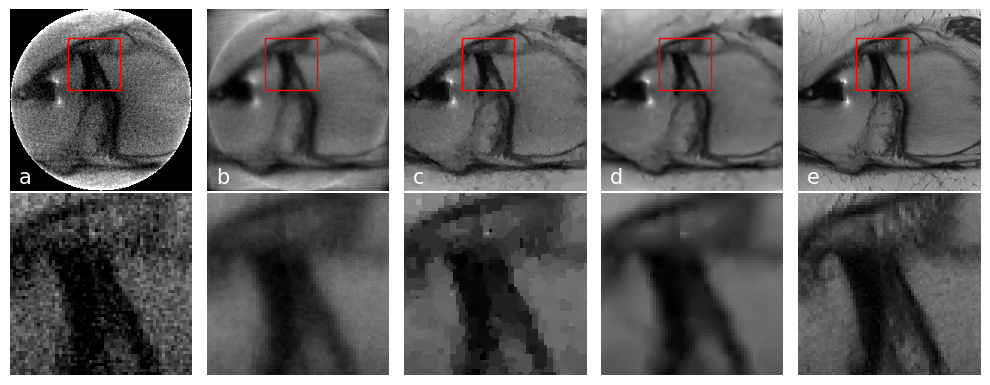

In [93]:
from matplotlib import patches

R = 2

np.random.seed(12) # seed = 12 produces white noise artifact

size = 211
A, M, gt, gt_sin, s, s_fbp, theta_fbp = get_operators_and_data(size=size, slice=50, acceleration_rate=R, xi=.05)


lam = optimal_lambdas[size][-1] # correct lambda for image size and noise level xi=0.5 <-> last item in list

# Reconstruct
x_fbp = FBP(s_fbp, theta_fbp)

TGV_solver = ADMM_TGV(lam)
x_tgv, _ = TGV_solver.solve(A, M, s)

TV_solver = ADMM_TV(lam=lam)
x_tv, _ = TV_solver.solve(A, M, s)

x_tikhonov = tikhonov(A, M, s, lam=TGV_solver.lam)

# Plot results
x, y = 33, 67
patch_size = 60

cmap = 'gray'
clim = [x_tgv.min(), x_tgv.max()]

fig, axs = plt.subplots(2,5, figsize=(10,4.5))

# Plot full images
axs[0,0].imshow(x_fbp, cmap=cmap, clim=clim)
axs[0,1].imshow(x_tikhonov, cmap=cmap, clim=clim)
axs[0,2].imshow(x_tv, cmap=cmap, clim=clim)
axs[0,3].imshow(x_tgv, cmap=cmap, clim=clim)
axs[0,4].imshow(gt, cmap=cmap, clim=clim)
for ax in axs[0,:]: # add patches
    rect = patches.Rectangle((y, x), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
# Plot patches
axs[1,0].imshow(x_fbp[x:x+patch_size, y:y+patch_size], cmap=cmap, clim=clim)
axs[1,1].imshow(x_tikhonov[x:x+patch_size, y:y+patch_size], cmap=cmap, clim=clim)
axs[1,2].imshow(x_tv[x:x+patch_size, y:y+patch_size], cmap=cmap, clim=clim)
axs[1,3].imshow(x_tgv[x:x+patch_size, y:y+patch_size], cmap=cmap, clim=clim)
axs[1,4].imshow(gt[x:x+patch_size, y:y+patch_size], cmap=cmap, clim=clim)

t_size = 15
pos = (10,x_tgv.shape[1]-10)
axs[0,0].text(*pos, 'a', color='white', size=t_size)
axs[0,1].text(*pos, 'b', color='white', size=t_size)
axs[0,2].text(*pos, 'c', color='white', size=t_size)
axs[0,3].text(*pos, 'd', color='white', size=t_size)
axs[0,4].text(*pos, 'e', color='white', size=t_size)

# LaTex tabular print
print('Method & nRMSE (\%) & PSNR (dB) & SSIM', end='\\\ \hline \n')
print(f'FBP & {nRMSE(x_fbp, gt)*100:.1f} & {PSNR(x_fbp, gt):.1f} & {SSIM(x_fbp, gt):.3f}', end='\\\ \n')
print(f'Tikhonov & {nRMSE(x_tikhonov, gt)*100:.1f} & {PSNR(x_tikhonov, gt):.1f} & {SSIM(x_tikhonov, gt):.3f}', end='\\\ \n')
print(f'TV & {nRMSE(x_tv, gt)*100:.1f} & {PSNR(x_tv, gt):.1f} & {SSIM(x_tv, gt):.3f}', end='\\\ \n')
print(f'TGV & {nRMSE(x_tgv, gt)*100:.1f} & {PSNR(x_tgv, gt):.1f} & {SSIM(x_tgv, gt):.3f}', end='\\\ \n')

for ax in axs.flatten():
    ax.axis('off')

plt.subplots_adjust(hspace=-0.4, wspace=0.05)
plt.tight_layout()
plt.savefig('figs/comparison.pdf', format='pdf')
plt.show()

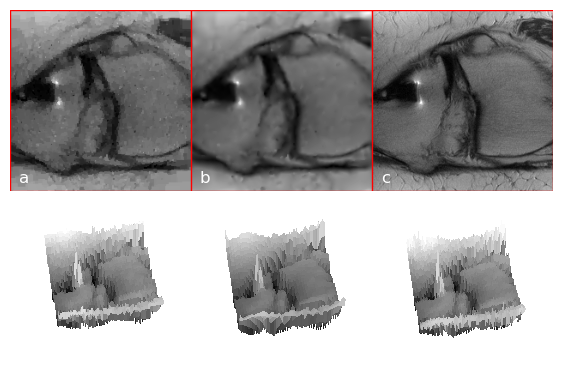

In [94]:
### NOT USED IN REPORT ###
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import proj3d

# Plot 3D comparison
x, y = 0,0
patch_size = 211

X = np.arange(x, x+patch_size, 1)
Y = np.arange(y, y+patch_size, 1)
X, Y = np.meshgrid(X, Y)
tv_patch = x_tv[x:x+patch_size, y:y+patch_size]
tgv_patch = x_tgv[x:x+patch_size, y:y+patch_size]
gt_patch = gt[x:x+patch_size, y:y+patch_size]

clim = [x_tgv.min(), x_tgv.max()]

fig = plt.figure(figsize=(7,5))

# Plot 2d images
ax0 = fig.add_subplot(2,3,1)
ax0.imshow(x_tv, cmap='gray', clim=clim)
ax0.text(10, x_tv.shape[0]-10, 'a', size=12, color='white')
ax0.axis('off')
rect = patches.Rectangle((y, x), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
ax0.add_patch(rect)

ax1 = fig.add_subplot(2,3,2)
ax1.imshow(x_tgv, cmap='gray', clim=clim)
ax1.text(10, x_tgv.shape[0]-10, 'b', size=12, color='white')
ax1.axis('off')
rect = patches.Rectangle((y, x), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)

ax2 = fig.add_subplot(2,3,3)
ax2.imshow(gt, cmap='gray', clim=clim)
ax2.text(10, gt.shape[0]-10, 'c', size=12, color='white')
ax2.axis('off')
rect = patches.Rectangle((y, x), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

# Plot 3d patch
ax3 = fig.add_subplot(2,3,4, projection='3d')
ax3.plot_surface(X, Y, tv_patch, cmap='gray',
                       linewidth=.0, edgecolor='white', antialiased=False)
ax4 = fig.add_subplot(2,3,5, projection='3d')
ax4.plot_surface(X, Y, tgv_patch, cmap='gray',
                       linewidth=.0, edgecolor='white', antialiased=False)
ax5 = fig.add_subplot(2,3,6, projection='3d')
ax5.plot_surface(X, Y, gt_patch, cmap='gray',
                       linewidth=.0, edgecolor='white', antialiased=False)
for ax in [ax3,ax4,ax5]: 
    ax.view_init(elev=50., azim=-100)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.axis('off')
    ax.invert_yaxis() # invert axis to mimic behavior of imshow

plt.savefig('figs/3d_comparison.pdf', format='pdf', bbox_inches="tight")
plt.subplots_adjust(hspace=-0.1, wspace=0)
plt.show()

### Acceleration rate comparison

In [95]:
### THIS TAKES ABOUT 8H FOR N=100 img_size=128 ON MAC M1 CHIP!!!

rates = np.array([1,2,4,7,10])

R = len(rates)
N = 500
slices = [x for x in range(0, N)]

acc_nrmse = {'tgv':np.zeros((R, N)), 'tv':np.zeros((R, N)), 'tik':np.zeros((R, N)), 'fbp':np.zeros((R, N))}
acc_psnr = {'tgv':np.zeros((R, N)), 'tv':np.zeros((R, N)), 'tik':np.zeros((R, N)), 'fbp':np.zeros((R, N))}
acc_ssim = {'tgv':np.zeros((R, N)), 'tv':np.zeros((R, N)), 'tik':np.zeros((R, N)), 'fbp':np.zeros((R, N))}

acc_errs = [acc_nrmse, acc_psnr, acc_ssim]
labels = ['tgv', 'tv', 'tik', 'fbp']

xi = 0.05
img_size = 64

for i, R in enumerate(rates):
    for j,slice in enumerate(slices):
        A, M, gt, gt_sin, s, s_fbp, theta_fbp = get_operators_and_data(size=img_size, slice=slice, acceleration_rate=R, xi=xi)

        TGV_solver = ADMM_TGV(lam=optimal_lambdas[img_size][-1])
        x_tgv, _ = TGV_solver.solve(A, M, s, cg_iter=30)

        TV_solver = ADMM_TV(lam=TGV_solver.lam)
        x_tv, _ = TV_solver.solve(A, M, s, cg_iter=30)

        x_tikhonov = tikhonov(A, M, s, lam=TGV_solver.lam)

        x_fbp = FBP(s_fbp, theta_fbp)

        X = [x_tgv, x_tv, x_tikhonov, x_fbp]

        for err, func in zip(acc_errs, [nRMSE, PSNR, SSIM]):
            for label, x in zip(labels, X):
                err[label][i,j] = func(x, gt)

    

ADMM time elapsed: 2.65
ADMM time elapsed: 2.07
ADMM time elapsed: 2.45
ADMM time elapsed: 0.78
ADMM time elapsed: 2.55
ADMM time elapsed: 1.0
ADMM time elapsed: 2.61
ADMM time elapsed: 1.34
ADMM time elapsed: 2.56
ADMM time elapsed: 0.39
ADMM time elapsed: 2.36
ADMM time elapsed: 0.39
ADMM time elapsed: 0.66
ADMM time elapsed: 1.18
ADMM time elapsed: 2.64
ADMM time elapsed: 0.43
ADMM time elapsed: 2.45
ADMM time elapsed: 0.22
ADMM time elapsed: 2.61
ADMM time elapsed: 1.51
ADMM time elapsed: 2.61
ADMM time elapsed: 1.04
ADMM time elapsed: 2.63
ADMM time elapsed: 0.3
ADMM time elapsed: 2.66
ADMM time elapsed: 0.48
ADMM time elapsed: 2.7
ADMM time elapsed: 1.13
ADMM time elapsed: 2.73
ADMM time elapsed: 2.11
ADMM time elapsed: 2.48
ADMM time elapsed: 0.74
ADMM time elapsed: 2.46
ADMM time elapsed: 0.26
ADMM time elapsed: 2.98
ADMM time elapsed: 1.22
ADMM time elapsed: 2.51
ADMM time elapsed: 0.9
ADMM time elapsed: 2.64
ADMM time elapsed: 1.34
ADMM time elapsed: 2.91
ADMM time elapsed: 1

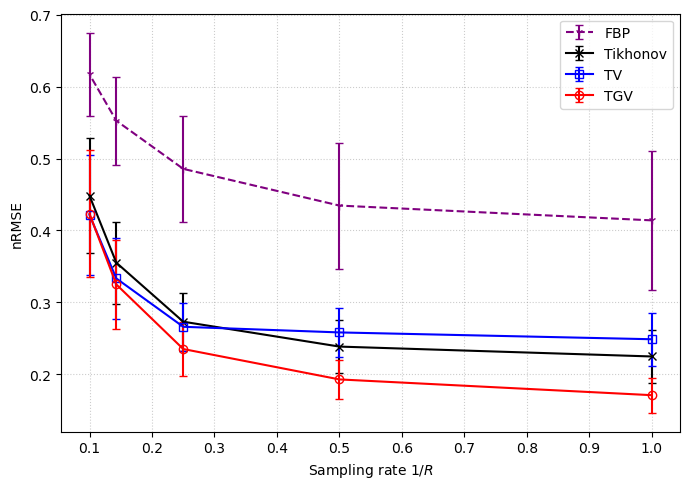

In [99]:
# Plot above results
fig, ax = plt.subplots(1,1, figsize=(7,5))

metric = 'nrmse' # plot a metric of your choice: 'ssim', 'nrmse' or 'psnr'

if metric == 'psnr':
    ploterr = acc_psnr 
    ylab = 'PSNR (dB)'
elif metric == 'ssim':
    ploterr = acc_ssim
    ylab = 'SSIM'
elif metric == 'nrmse':
    ploterr = acc_nrmse
    ylab = 'nRMSE'

c = 3

ax.errorbar(1/rates, ploterr['fbp'].mean(axis=1), fmt='1--', color='purple', 
            label='FBP', yerr=ploterr['fbp'].std(axis=1), fillstyle='none',capsize=c)

ax.errorbar(1/rates, ploterr['tik'].mean(axis=1), fmt='x-', color='black', 
            label='Tikhonov', yerr=ploterr['tik'].std(axis=1), fillstyle='none',capsize=c)

ax.errorbar(1/rates, ploterr['tv'].mean(axis=1), fmt='s-', color='blue', 
            label='TV', yerr=ploterr['tv'].std(axis=1), fillstyle='none',capsize=c)

ax.errorbar(1/rates, ploterr['tgv'].mean(axis=1), fmt='o-', color='red', 
            label='TGV', yerr=ploterr['tgv'].std(axis=1), fillstyle='none',capsize=c)

plt.xlabel(r'Sampling rate $1/R$')
plt.ylabel(ylab)

ax.grid('on', color='gray', alpha=0.4, linestyle='dotted')
ax.legend()
plt.xticks(np.arange(0.1,1.1,0.1))

plt.tight_layout()
#plt.savefig(f'figs/{metric}_xi_{xi}_{img_size}.pdf', format='pdf')
plt.show()

### Sampling rate comparison

ADMM time elapsed: 118.77
ADMM time elapsed: 88.32
ADMM time elapsed: 105.71
ADMM time elapsed: 81.72
ADMM time elapsed: 96.93
ADMM time elapsed: 78.05
ADMM time elapsed: 93.57
ADMM time elapsed: 74.17


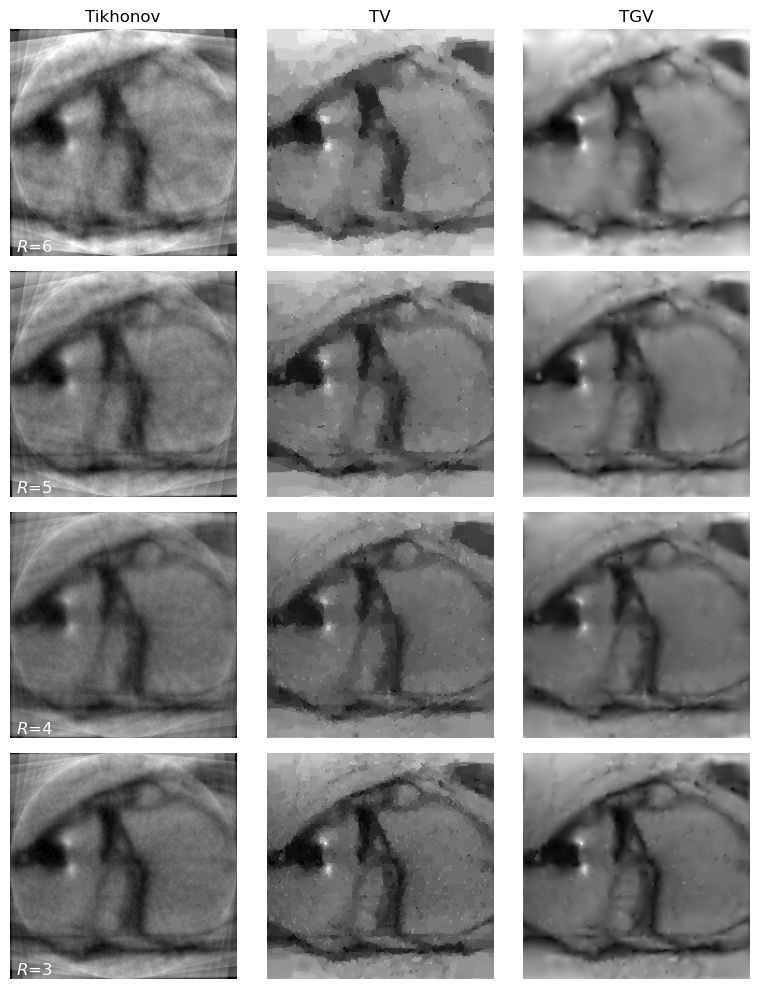

In [44]:
fig, axs = plt.subplots(4, 3, figsize=(8,10))

Rs = [6, 5, 4, 3]

t_size = 12


cmap = 'gray'

for i, R in enumerate(Rs):
    A, M, gt, gt_sin, s, s_fbp, theta_fbp = get_operators_and_data(size=211, slice=50, acceleration_rate=R, xi=0.05)

    lam, rho = .9, 30
    TGV_solver = ADMM_TGV(lam, rho, rho, 2, 1)
    x_tgv, _ = TGV_solver.solve(A, M, s, maxiter=100, cg_iter=100, tol=1e-3)

    TV_solver = ADMM_TV(lam=lam, rho=rho)
    x_tv, _ = TV_solver.solve(A, M, s, maxiter=100, cg_iter=100, tol=1e-3)

    x_tikhonov = tikhonov(A, M, s, lam=lam)

    clim = [x_tikhonov.min(), x_tikhonov.max()]

    axs[i,0].imshow(x_tikhonov, cmap=cmap, clim=[x_tgv.min(), x_tgv.max()])
    axs[i,1].imshow(x_tv, cmap=cmap, clim=[x_tgv.min(), x_tgv.max()])
    axs[i,2].imshow(x_tgv, cmap=cmap, clim=[x_tgv.min(), x_tgv.max()])

    pos = (5, x_tgv.shape[1]-5)

    axs[i,0].text(*pos, f'$R$={R}', color='white', size=t_size)

axs[0,0].set_title('Tikhonov')
axs[0,1].set_title('TV')
axs[0,2].set_title('TGV')

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.savefig('figs/R_pics.pdf', format='pdf')
plt.show()
    

# Rho vs. reconstruction time and cost
Investigate how $\rho$ affects reconstruction time, iteration time and the converged cost value. 

In [57]:
rhos = np.arange(1,110, step=10)
N = 200
slices = [x for x in range(N)]

rho_time = np.zeros((len(rhos), 3, N)) # Recon time, mean iter time, for each slice

for i, r in enumerate(rhos):
    for j,slice in enumerate(slices):
        A, M, gt, gt_sin, s, s_fbp, theta_fbp = get_operators_and_data(size=64, slice=slice, acceleration_rate=1, xi=0.05)


        TGV_solver = ADMM_TGV(.9, r, r)
        x_tgv, t_tgv = TGV_solver.solve(A, M, s)

        rho_time[i,0,j] = t_tgv
        rho_time[i,1,j] = TGV_solver.info['mean_iter_time']
        rho_time[i,2,j] = TGV_solver.info['cost_func'][-1]

ADMM time elapsed: 16.59
ADMM time elapsed: 15.23
ADMM time elapsed: 15.45
ADMM time elapsed: 15.2
ADMM time elapsed: 15.09
ADMM time elapsed: 15.13
ADMM time elapsed: 15.38
ADMM time elapsed: 15.26
ADMM time elapsed: 8.27
ADMM time elapsed: 15.24
ADMM time elapsed: 15.25
ADMM time elapsed: 15.73
ADMM time elapsed: 15.22
ADMM time elapsed: 15.45
ADMM time elapsed: 15.4
ADMM time elapsed: 15.15
ADMM time elapsed: 15.19
ADMM time elapsed: 15.17
ADMM time elapsed: 15.32
ADMM time elapsed: 15.32
ADMM time elapsed: 15.06
ADMM time elapsed: 15.3
ADMM time elapsed: 15.48
ADMM time elapsed: 15.48
ADMM time elapsed: 15.16
ADMM time elapsed: 14.88
ADMM time elapsed: 15.19
ADMM time elapsed: 15.51
ADMM time elapsed: 15.11
ADMM time elapsed: 15.83
ADMM time elapsed: 15.33
ADMM time elapsed: 15.44
ADMM time elapsed: 15.46
ADMM time elapsed: 15.43
ADMM time elapsed: 8.7
ADMM time elapsed: 15.38
ADMM time elapsed: 15.21
ADMM time elapsed: 15.18
ADMM time elapsed: 15.26
ADMM time elapsed: 15.29
ADMM t

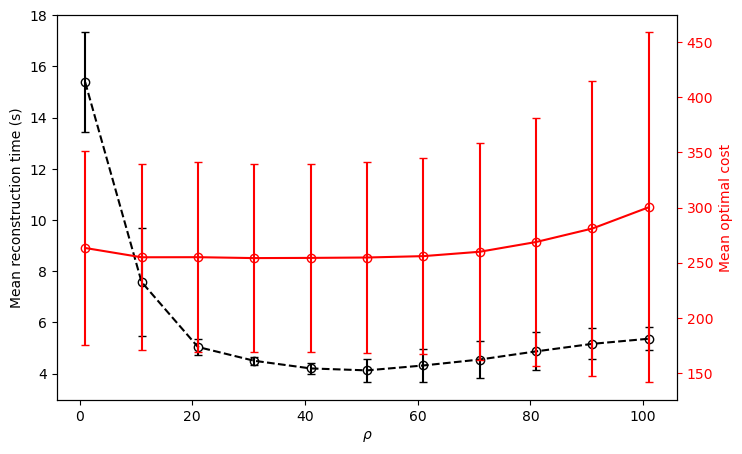

In [59]:
# Plot above results
fig, ax = plt.subplots(1,1, figsize=(8,5))

col1, col2 = 'black', 'red'

y = np.mean(rho_time[:,0,:], axis=1)
y_err = np.std(rho_time[:,0,:], axis=1)
ax.errorbar(rhos, y, fmt='o--', color=col1, yerr=y_err, fillstyle='none', capsize=3)
#ax.plot(rhos, y, 'o-', color=col1)
#ax.fill_between(rhos, y-y_err, y+y_err, alpha=0.1, color=col1, antialiased=True)
ax.tick_params(axis='y', colors=col1)

ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'Mean reconstruction time (s)')

ax = ax.twinx()

y = np.mean(rho_time[:,2,:], axis=1)
y_err = np.std(rho_time[:,2,:], axis=1)
ax.errorbar(rhos, y, fmt='o-', color=col2, yerr=y_err, fillstyle='none', capsize=3)
#ax.plot(rhos, y, 'o-', color=col2)
#ax.fill_between(rhos, y-y_err, y+y_err, alpha=0.1, color=col2, antialiased=True)
ax.tick_params(axis='y', colors=col2)

ax.set_ylabel(r'Mean optimal cost', color=col2)

plt.savefig('figs/rho_vs_time.pdf', format='pdf')

plt.show()

## Image size vs. Time

In [53]:
sizes = [16 + 39*x for x in range(0,6)]
print(sizes)
N = 25
slices = [x for x in range(N)]

tgv_time = np.zeros((len(sizes), N)) # time, nRMSE, slices
tv_time = np.zeros((len(sizes), N))

tol = 1e-3

for i,size in enumerate(sizes):
    for j,slice in enumerate(slices):
        A, M, gt, gt_sin, s, *_ = get_operators_and_data(size=size, slice=50, acceleration_rate=1, xi=0.05)
        
        TGV_solver = ADMM_TGV(.9)
        x_tgv, t_tgv = TGV_solver.solve(A, M, s, maxiter=100, tol=tol)

        TV_solver = ADMM_TV(lam=TGV_solver.lam)
        x_tv, t_tv = TV_solver.solve(A, M, s, maxiter=100, tol=tol)

        tv_time[i,j] = t_tv
        tgv_time[i,j] = t_tgv

[16, 55, 94, 133, 172, 211]
ADMM time elapsed: 0.61
ADMM time elapsed: 0.15
ADMM time elapsed: 0.61
ADMM time elapsed: 0.27
ADMM time elapsed: 0.61
ADMM time elapsed: 0.28
ADMM time elapsed: 0.6
ADMM time elapsed: 0.29
ADMM time elapsed: 0.64
ADMM time elapsed: 0.28
ADMM time elapsed: 0.61
ADMM time elapsed: 0.29
ADMM time elapsed: 0.1
ADMM time elapsed: 0.27
ADMM time elapsed: 0.61
ADMM time elapsed: 0.29
ADMM time elapsed: 0.6
ADMM time elapsed: 0.28
ADMM time elapsed: 0.62
ADMM time elapsed: 0.12
ADMM time elapsed: 0.62
ADMM time elapsed: 0.28
ADMM time elapsed: 0.58
ADMM time elapsed: 0.28
ADMM time elapsed: 0.61
ADMM time elapsed: 0.3
ADMM time elapsed: 0.62
ADMM time elapsed: 0.27
ADMM time elapsed: 0.63
ADMM time elapsed: 0.29
ADMM time elapsed: 0.62
ADMM time elapsed: 0.28
ADMM time elapsed: 0.59
ADMM time elapsed: 0.27
ADMM time elapsed: 0.63
ADMM time elapsed: 0.31
ADMM time elapsed: 0.62
ADMM time elapsed: 0.14
ADMM time elapsed: 0.6
ADMM time elapsed: 0.11
ADMM time elapsed

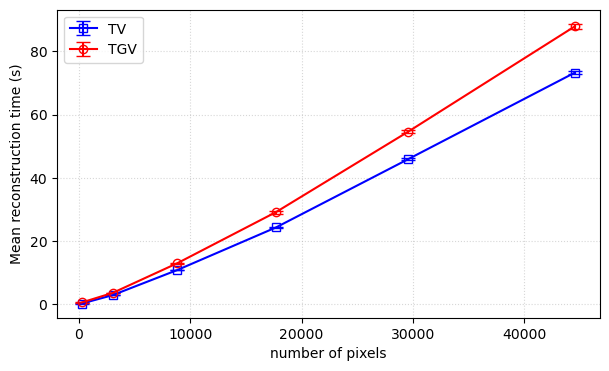

In [55]:
# Plot above results
fig, ax = plt.subplots(1, 1, figsize=(7,4))
ax.errorbar(np.array(sizes)**2, tv_time.mean(axis=1), fmt='s-', color='blue', fillstyle='none', label='TV', yerr=tv_time.std(axis=1), capsize=5)
ax.errorbar(np.array(sizes)**2, tgv_time.mean(axis=1), fmt='o-', color='red', fillstyle='none', label='TGV', yerr=tgv_time.std(axis=1), capsize=5)
ax.set_xlabel('number of pixels')
ax.set_ylabel('Mean reconstruction time (s)')
plt.legend()
plt.grid('on', alpha=0.5, linestyle='dotted')
plt.savefig('figs/timecomplexity.pdf', format='pdf')
